# Estimate Atmospheric Parameters


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in

https://github.com/sylvielsstfr/SpectractorAnaAtm19/blob/master/ana_20190215_HD116405_Filtre_None/ConvertSpectraToPandas.ipynb

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : October 9th 2020




# Import

In [207]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [208]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [209]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [210]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [211]:
from scipy import interpolate

In [212]:
import pickle
from joblib import load

In [213]:
from sklearn import linear_model

# Functions

In [214]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [215]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

In [216]:
def GetSpectra(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectra(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        #if idx>160 and idx<200:
        #    idx+=1
        #    continue
        
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [217]:
def GetSpectraFiltered(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        if idx>160 and idx<200:
            idx+=1
            continue
        if idx>220 and idx<226:
            idx+=1
            continue
        if idx>275 and idx<295:
        #if idx>260 and idx<295:
            idx+=1
            continue
            
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [218]:
def ConvertToImage(all_df,WLMIN=350,WLMAX=1100):
    """
    ConvertToImage(all_df,WLMIN=350,WLMAX=1100)
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        fcn = interpolate.interp1d(df.wavelength,df.mag,bounds_error=False,fill_value=(0,0))
        mag_table[idx,:] = fcn(WL) 
        airm_table[idx]  = df.airmass[0]
        time_table[idx]  = df.time[0]
        
    return WL, mag_table, airm_table,time_table
       

In [219]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs time")
        plt.show()
     
    return 
     

In [220]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [221]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [222]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-10-12 16:04:55,767 MacBook-Pro-de-admin.local __main__[44777] INFO LA time:07:04:55
2020-10-12 16:04:55,768 MacBook-Pro-de-admin.local __main__[44777] INFO NY time:10:04:55
2020-10-12 16:04:55,769 MacBook-Pro-de-admin.local __main__[44777] INFO London time:15:04:55
2020-10-12 16:04:55,769 MacBook-Pro-de-admin.local __main__[44777] INFO Paris time:16:04:55
2020-10-12 16:04:55,770 MacBook-Pro-de-admin.local __main__[44777] INFO ************************ START *********************


In [223]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [224]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-10-12 16:04:55,784 MacBook-Pro-de-admin.local __main__[44777] INFO Configuration file : config/default.ini


In [225]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-10-12 16:04:55,791 MacBook-Pro-de-admin.local __main__[44777] INFO 1) Configuration


In [226]:
config_section = config.sections()

In [227]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [228]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)
    
   
if 'ATMOSPHERE' in config_section:
    inputdir_atm  =  config['ATMOSPHERE']['inputdir_atm']
    inputfile_atm = config['ATMOSPHERE']['inputfile_atm'] 
    
    basefilename_atm=inputfile_atm.split(".")[0]  
    
    packetsize = int(config['ATMOSPHERE']['packetsize'])
    maxnbpacket = int(config['ATMOSPHERE']['maxnbpacket'])
    
else:
    msg = f"Configuration file : empty section ATMOSPHERE in config file {config_filename} !"   
    logger.error(msg)
      
    
if 'ML' in config_section:
# scaler data in ../MLfit_atm2_data

    file_scaler_wl      = config['ML']['file_scaler_wl']
    file_scaler_ymean   = config['ML']['file_scaler_ymean']
    file_scaler_yvar    = config['ML']['file_scaler_yvar']
    file_scaler_yscale  = config['ML']['file_scaler_yscale']
    file_scaler_xmean   = config['ML']['file_scaler_xmean']
    file_scaler_xvar    = config['ML']['file_scaler_xvar']
    file_scaler_xscale  = config['ML']['file_scaler_xscale']
    
    file_scaler_x       = config['ML']['file_scaler_x']
    file_scaler_y       = config['ML']['file_scaler_y']
else:
    msg = f"Configuration file : empty section ML in config file {config_filename} !"   
    logger.error(msg)

if 'SIMULATION' in config_section:

    file_specsim_order12 = config['SIMULATION']['file_specsim_order12']
    file_specsim_order2  = config['SIMULATION']['file_specsim_order2']


    file_model_linearregression       = config['SIMULATION']['file_model_linearregression']
    file_model_linearregression_ridge = config['SIMULATION']['file_model_linearregression_ridge']
    file_model_linearregression_lasso = config['SIMULATION']['file_model_linearregression_lasso']
else:
    msg = f"Configuration file : empty section SIMULATION in config file {config_filename} !"   
    logger.error(msg)

In [229]:
msg=f" Object observed {target}"
logger.info(msg)

2020-10-12 16:04:55,844 MacBook-Pro-de-admin.local __main__[44777] INFO  Object observed HD116405


In [230]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

# input files

## sed

In [231]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [232]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [233]:
sed_m=-2.5*np.log10(sed_f)

## Atmosphere parameters for simulation

In [234]:
all_files = os.listdir(inputdir_atm)
sorted_files=sorted(all_files)

# search string
search_str="^"+f"{basefilename_atm}.*fits$"

selected_atmfiles=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_atmfiles.append(file)
        
if maxnbpacket>0:
    selected_atmfiles=selected_atmfiles[:maxnbpacket]

In [235]:
wl_atm0,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(inputdir_atm ,selected_atmfiles)

In [236]:
num_atmsim     = datain[0:,idx_num]
airmass_atmsim = datain[0:,idx_am]
vaod_atmsim    = datain[0:,idx_vaod] # vertical aerosol depth
pwv_atmsim     = datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone_atmsim   = datain[0:,idx_o3]     # ozone
cld_atmsim     = datain[0:,idx_cld]   # clouds (not us

In [237]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [238]:
airmassarr=airmass[:,np.newaxis]
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=ozone[:,np.newaxis]
cldarr=cld[:,np.newaxis]

In [239]:
Ysim=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
Ylabel=["vaod","pwv","ozone","cld"]

## Simulation of Spectra

In [240]:
wl_atm=np.load(file_scaler_wl)
spec_sim=np.load(file_specsim_order12)

### Apply attenuation by clouds

In [241]:
spec_sim=spec_sim*np.exp(-airmassarr*cldarr)

In [242]:
iy,ix=np.where(spec_sim==spec_sim.max())

In [243]:
spec_sim_max=spec_sim[iy[0],ix[0]]

In [244]:
spec_sim_max

5.0733307947166304e-12

In [245]:
NSIM=spec_sim.shape[0]

## data

In [246]:
inputdir_good="data_clean"
inputdir_bad="data_bad"

In [247]:
all_files_good = os.listdir(inputdir_good)
sorted_files_good=sorted(all_files_good)

In [248]:
all_files_bad = os.listdir(inputdir_bad)
sorted_files_bad=sorted(all_files_bad)

In [249]:
# search string
search_str="^"+f"{basefilename}.*csv$"

In [250]:
selected_files_good=[]
for file in sorted_files_good:
    if re.search(search_str,file):
        selected_files_good.append(file)

In [251]:
selected_files_bad=[]
for file in sorted_files_bad:
    if re.search(search_str,file):
        selected_files_bad.append(file)

In [252]:
NBFILES_GOOD=len(selected_files_good)
NBFILES_BAD=len(selected_files_bad)

In [253]:
msg=f" Number of good selected files is {NBFILES_GOOD}"
logger.info(msg)

2020-10-12 16:04:56,296 MacBook-Pro-de-admin.local __main__[44777] INFO  Number of good selected files is 276


In [254]:
msg=f" Number of bad selected files is {NBFILES_BAD}"
logger.info(msg)

2020-10-12 16:04:56,303 MacBook-Pro-de-admin.local __main__[44777] INFO  Number of bad selected files is 71


## Read all data files spectra

In [255]:
all_df_good=GetSpectra(inputdir_good,selected_files_good,normalisation_factor=normalisation_factor)
all_df_bad=GetSpectra(inputdir_bad,selected_files_bad,normalisation_factor=normalisation_factor)

In [256]:
NBFILES_GOOD=len(all_df_good)
NBFILES_BAD=len(all_df_bad)

In [257]:
msg=f" Number of good spectra is {NBFILES_GOOD}"
logger.info(msg)

2020-10-12 16:04:59,491 MacBook-Pro-de-admin.local __main__[44777] INFO  Number of good spectra is 275


In [258]:
msg=f" Number of good spectra is {NBFILES_BAD}"
logger.info(msg)

2020-10-12 16:04:59,496 MacBook-Pro-de-admin.local __main__[44777] INFO  Number of good spectra is 70


In [259]:
def FLAG_Spectra(idx):
    """
    """
      
    flag=True
    
    if idx>160 and idx<200:
        return False
    
    if idx>220 and idx<226:
        return False
    
    if idx>275 and idx<295:
        return False
        
    return flag

In [260]:
spectra_indexes=np.arange(NBFILES_GOOD)
flag_spectra= [FLAG_Spectra(idx) for idx in spectra_indexes]
flag_spectra=np.array(flag_spectra)

## Find the maximum in the data

In [261]:
all_flux_max=[]
for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]
    the_flux=the_df.flux.values
    the_fluxmax=the_flux.max()
    all_flux_max.append(the_fluxmax)

In [262]:
#for ifile in np.arange(NBFILES_BAD):
#    the_df=all_df_bad[ifile]
#    the_flux=the_df.flux.values
#    the_fluxmax=the_flux.max()
#    all_flux_max.append(the_fluxmax)

In [263]:
all_flux_max=np.array(all_flux_max)

In [264]:
the_fluxmax_data=all_flux_max.max()

In [265]:
the_fluxmax_data

4.184461870024858e-12

# Normalisation of simulation

In [266]:
norm_datasim=spec_sim_max/the_fluxmax_data

(0.0, 6e-12)

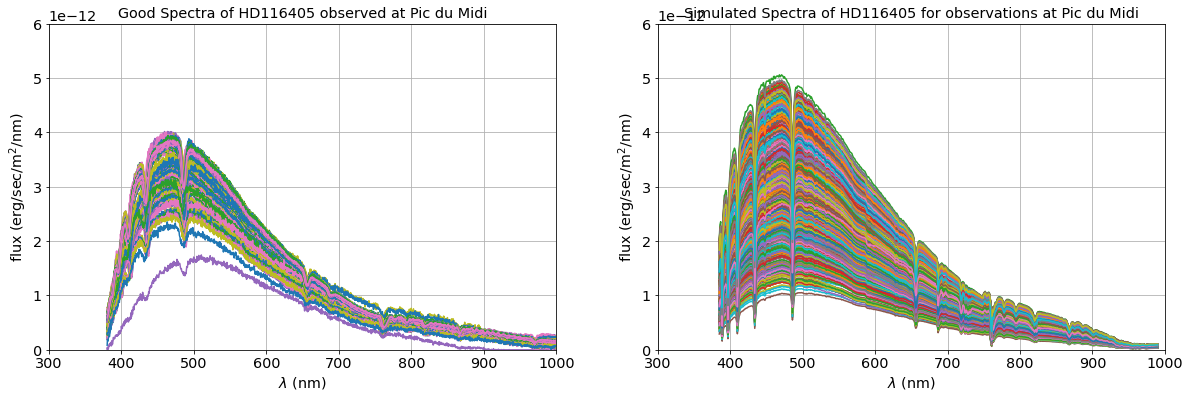

In [267]:
fig=plt.figure(figsize=(20,6))

#-----
ax=fig.add_subplot(121)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_GOOD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_GOOD), alpha=1)

for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]

    #ax.plot(the_df.wavelength,the_df.flux*norm_datasim,color=all_colors[ifile])
    if ifile < 152 or ifile>202:
        ax.plot(the_df.wavelength,the_df.flux,all_colors[ifile])
   
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Good Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1000)
ax.set_ylim(0,6e-12)

#-----
ax=fig.add_subplot(122)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_BAD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_BAD), alpha=1)

for ifile in np.arange(2000):
    ax.plot(wl_atm,spec_sim[ifile,:])
    #ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '.', color=all_colors[ifile],capsize = .01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Simulated Spectra of {target} for observations at Pic du Midi"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1000)
ax.set_ylim(0,6e-12)

# Start Machine Learning

## Setup Scaler

In [268]:
NWL=len(wl_atm)

In [269]:
scaler_ymean=np.load(file_scaler_ymean) 
scaler_yvar=np.load(file_scaler_yvar) 
scaler_yscale=np.load(file_scaler_yscale)  
scaler_xmean=np.load(file_scaler_xmean) 
scaler_xvar=np.load(file_scaler_xvar) 
scaler_xscale=np.load(file_scaler_xscale) 

In [270]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [271]:
scaler_X.mean_=scaler_xmean
scaler_X.scale_=scaler_xscale
scaler_X.var_=scaler_xvar

In [272]:
scaler_Y.mean_=scaler_ymean
scaler_Y.scale_=scaler_yscale
scaler_Y.var_=scaler_yvar

In [273]:
scaler_X0 = load(file_scaler_x)       
scaler_Y0 = load(file_scaler_y)        

In [274]:
scaler_Y0.scale_

array([3.32374886e-02, 2.75479607e+00, 1.15058362e+02, 1.25597467e-01])

In [275]:
scaler_Y.scale_

array([3.32374886e-02, 2.75479607e+00, 1.15058362e+02, 1.25597467e-01])

In [276]:
scaler_yvar

array([1.10473065e-03, 7.58890141e+00, 1.32384266e+04, 1.57747237e-02])

In [277]:
scaler_Y0.var_

array([1.10473065e-03, 7.58890141e+00, 1.32384266e+04, 1.57747237e-02])

Text(0.5, 1.05, 'Scaling coefficients for X')

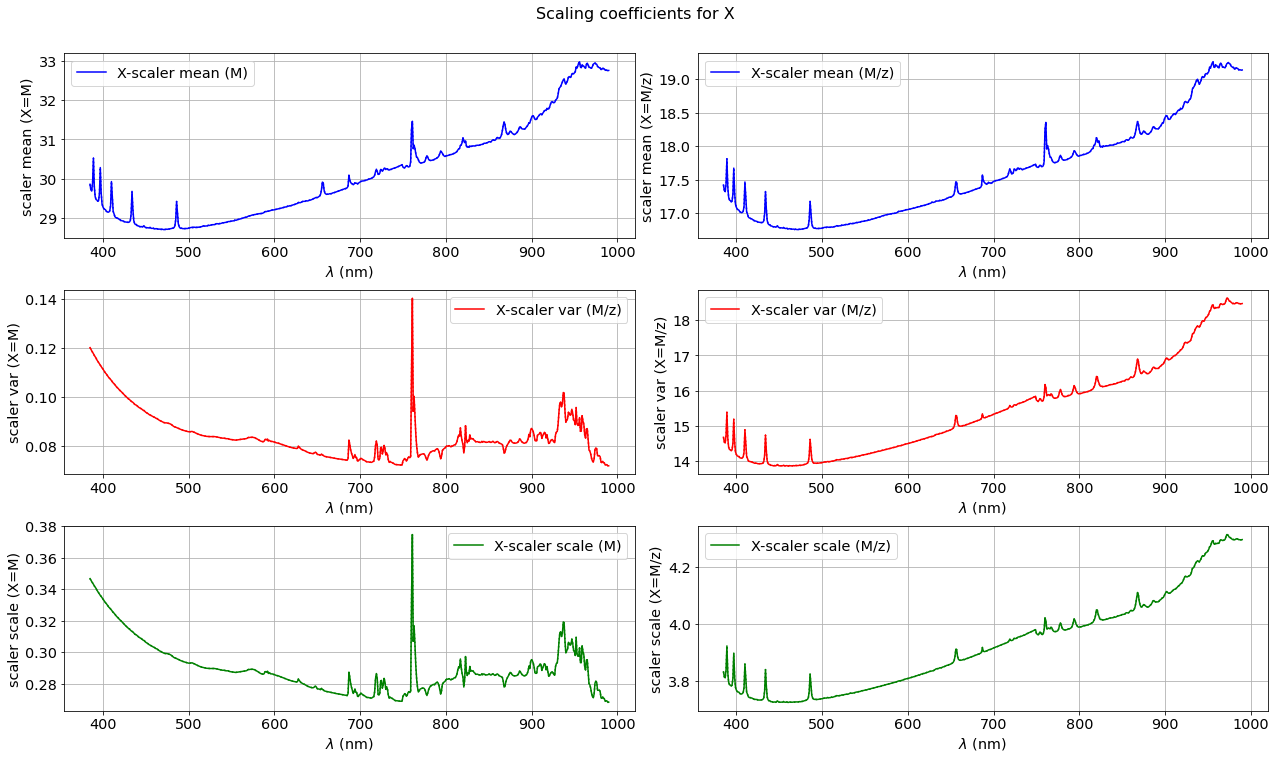

In [278]:
fig=plt.figure(figsize=(18,10))

ax = fig.add_subplot(321)
ax.plot(wl_atm,scaler_X0.mean_[0:NWL],'b-',label="X-scaler mean (M)")
ax.plot(wl_atm,scaler_xmean[0:NWL],'b:')
        
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("scaler mean (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(322)
ax.plot(wl_atm,scaler_X0.mean_[NWL:2*NWL],'b-',label="X-scaler mean (M/z)")
ax.plot(wl_atm,scaler_xmean[NWL:2*NWL],'b:')
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("scaler mean (X=M/z)")
ax.grid()
ax.legend()

ax = fig.add_subplot(323)
ax.plot(wl_atm,scaler_X0.var_[0:NWL],'r-',label="X-scaler var (M/z)")
ax.plot(wl_atm,scaler_xvar[0:NWL],'r:')
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("scaler var (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(324)
ax.plot(wl_atm,scaler_X0.var_[NWL:2*NWL],'r-',label="X-scaler var (M/z)")
ax.plot(wl_atm,scaler_xvar[NWL:2*NWL],'r:')
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("scaler var (X=M/z)")
ax.grid()
ax.legend()

ax = fig.add_subplot(325)
ax.plot(wl_atm,scaler_X0.scale_[0:NWL],'g-',label="X-scaler scale (M)")
ax.plot(wl_atm,scaler_xscale[0:NWL],'g:')
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("scaler scale (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(326)
ax.plot(wl_atm,scaler_X0.scale_[NWL:2*NWL],'g-',label="X-scaler scale (M/z)")
ax.plot(wl_atm,scaler_xscale[NWL:2*NWL],'g:')
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("scaler scale (X=M/z)")
ax.grid()
ax.legend()

plt.tight_layout()
plt.suptitle("Scaling coefficients for X",Y=1.05,fontsize=16)

# Linear Regression Model 

## Read coefficient from files ridge file

In [279]:
#with open(file_model_linearregression, 'rb') as file:
#    linearregression_model = pickle.load(file)

In [280]:
with open(file_model_linearregression_ridge, 'rb') as file:
    linearregression_model = pickle.load(file)

In [281]:
linearregression_model.coef_.shape

(4, 1212)

In [282]:
thecoef=linearregression_model.coef_

In [283]:
thecoef[0].shape

(1212,)

Text(0.5, 1.05, 'Coefficients for X')

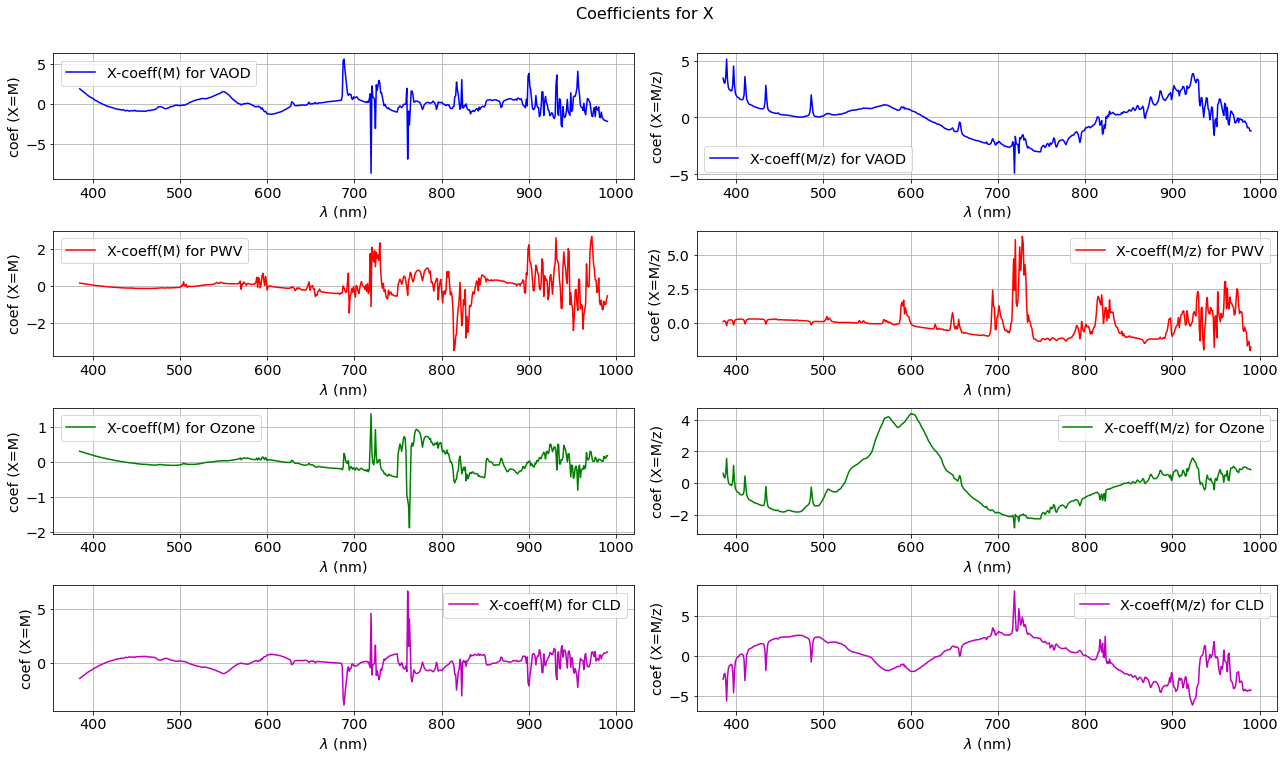

In [284]:
fig=plt.figure(figsize=(18,10))

ax = fig.add_subplot(421)
ax.plot(wl_atm,thecoef[0][0:NWL],'b-',label="X-coeff(M) for VAOD")        
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(422)
ax.plot(wl_atm,thecoef[0][NWL:2*NWL],'b-',label="X-coeff(M/z) for VAOD")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M/z)")
ax.grid()
ax.legend()


ax = fig.add_subplot(423)
ax.plot(wl_atm,thecoef[1][0:NWL],'r-',label="X-coeff(M) for PWV")        
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(424)
ax.plot(wl_atm,thecoef[1][NWL:2*NWL],'r-',label="X-coeff(M/z) for PWV")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M/z)")
ax.grid()
ax.legend()


ax = fig.add_subplot(425)
ax.plot(wl_atm,thecoef[2][0:NWL],'g-',label="X-coeff(M) for Ozone")        
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(426)
ax.plot(wl_atm,thecoef[2][NWL:2*NWL],'g-',label="X-coeff(M/z) for Ozone")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M/z)")
ax.grid()
ax.legend()

ax = fig.add_subplot(427)
ax.plot(wl_atm,thecoef[3][0:NWL],'m-',label="X-coeff(M) for CLD")        
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M)")
ax.grid()
ax.legend()

ax = fig.add_subplot(428)
ax.plot(wl_atm,thecoef[3][NWL:2*NWL],'m-',label="X-coeff(M/z) for CLD")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("coef (X=M/z)")
ax.grid()
ax.legend()

plt.tight_layout()
plt.suptitle("Coefficients for X",Y=1.05,fontsize=16)

# Prepare X

In [285]:
NWL=len(wl_atm)

Xsim=np.zeros((NSIM,2*NWL))
X=np.zeros((NBFILES_GOOD,2*NWL))
am=np.zeros(NBFILES_GOOD)
t=np.zeros(NBFILES_GOOD)

## Fill Xsim

In [286]:
for isim in np.arange(NSIM):
    x2=-2.5*np.log10(spec_sim[isim,:])/airmass_atmsim[isim]
    x1=-2.5*np.log10(spec_sim[isim,:])
    
    x=np.concatenate((x1,x2))
    Xsim[isim,:]=x   

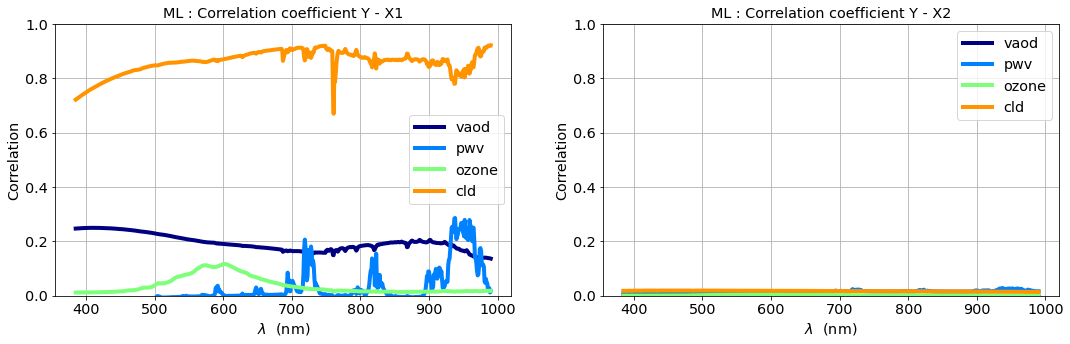

In [287]:
if FLAG_PLOT: 

    X1=Xsim[:,:NWL]
    X2=Xsim[:,NWL:2*NWL]
    Y=Ysim
    
    fig = plt.figure(figsize=(18, 5))
    
    
    
    ax = fig.add_subplot(121) 
    
    Ny=Y.shape[1]
    Nx=X1.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X1[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl_atm,corr[iy,:],color=all_colors[iy],label=Ylabel[iy],lw=4)
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("ML : Correlation coefficient Y - X1")
    ax.grid()
    ax.set_ylim(0,1)    
    
    
    ax = fig.add_subplot(122) 
    
    Ny=Y.shape[1]
    Nx=X2.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X2[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl_atm,corr[iy,:],color=all_colors[iy],label=Ylabel[iy],lw=4)
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("ML : Correlation coefficient Y - X2")
    ax.grid()
    ax.set_ylim(0,1)   
    

### Scaler for sim

In [288]:
scalersim_X = StandardScaler()
scalersim_Y = StandardScaler()

In [289]:
scalersim_X.fit(Xsim) 
scalersim_Y.fit(Ysim) 

StandardScaler()

In [290]:
scalersim_X.mean_

array([29.85466285, 29.71323832, 29.6835406 , ..., 19.11727583,
       19.11208453, 19.11611442])

In [291]:
scaler_X.mean_

array([29.85546232, 29.7140383 , 29.68434112, ..., 19.13498437,
       19.12976903, 19.13380925])

In [292]:
scalersim_Y.mean_

array([6.27158172e-02, 6.01156099e+00, 2.99087470e+02, 1.23719206e-01])

In [293]:
scaler_Y.mean_

array([6.29438593e-02, 6.03842264e+00, 2.98483867e+02, 1.24041672e-01])

## Fill X

In [294]:
for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]
    
    airmass=the_df["airmass"][0]
    data_wl=the_df["wavelength"].values
    #data_spectra=the_df["flux"].values*norm_datasim
    data_spectra=the_df["flux"].values
    
    func=interpolate.interp1d(data_wl,data_spectra,bounds_error=False,fill_value=(0,0))
    #func=interpolate.interp1d(data_wl,data_spectra)
    
    
    x2=-2.5*np.log10(func(wl_atm))/airmass
    x1=-2.5*np.log10(func(wl_atm))
    x=np.concatenate((x1,x2))
    
    X[ifile,:]=x
    am[ifile]=airmass 
   

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


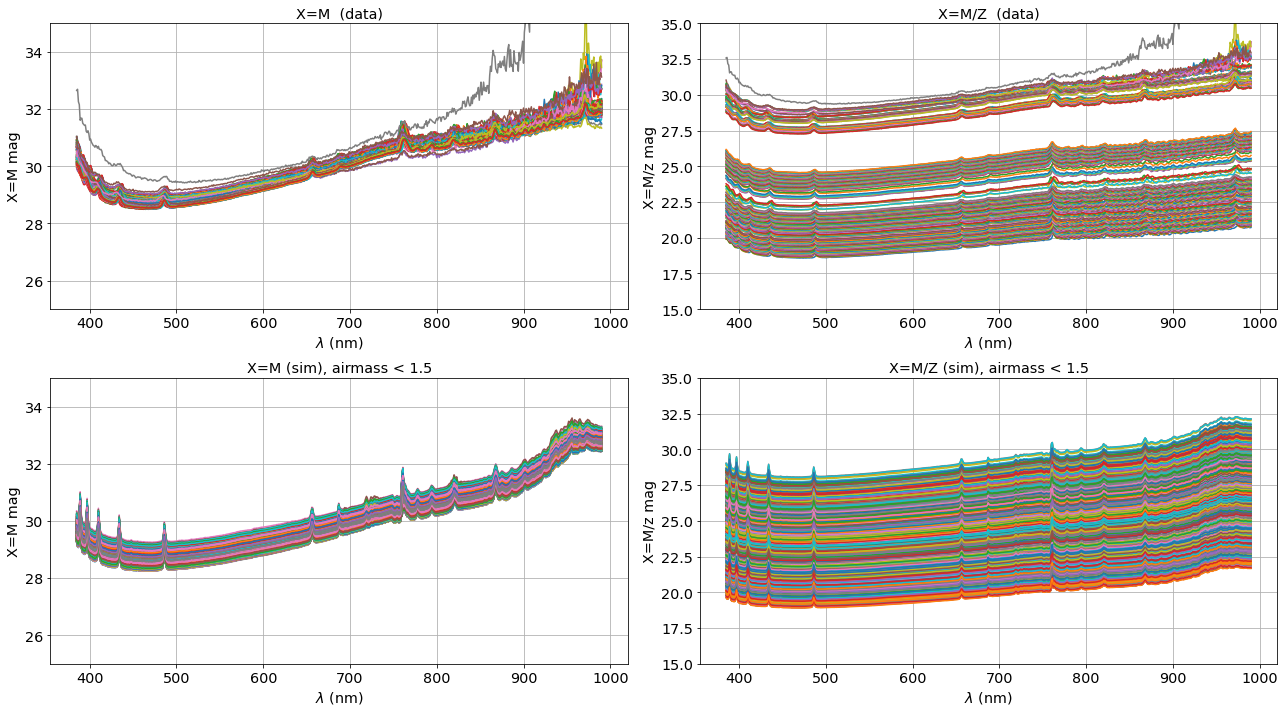

In [295]:
if FLAG_PLOT:
    N=NBFILES_GOOD
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(18,10))
    
    
    ax = fig.add_subplot(221)
    for idx in np.arange(N):
        if idx <152 or idx> 202:
        #if idx <152 :
            ax.plot(wl_atm,X[idx,:NWL])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.set_title("X=M  (data)")
    ax.set_ylim(25,35)
    
    ax = fig.add_subplot(222)
    for idx in np.arange(N):
        if idx <152 or idx> 202:
        #if idx <152 :
            ax.plot(wl_atm,X[idx,NWL:2*NWL])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M/z mag")
    ax.grid()
    ax.set_title("X=M/Z  (data)")
    ax.set_ylim(15,35)
    
    
    
     
    ax = fig.add_subplot(223)
    for idx in np.arange(10000):
        if airmass_atmsim[idx]<=1.5:
            ax.plot(wl_atm,Xsim[idx,:NWL])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.set_title("X=M (sim), airmass < 1.5")

    ax.set_ylim(25,35)
    
    
    ax = fig.add_subplot(224)
    for idx in np.arange(10000):
        if airmass_atmsim[idx]<=1.5:
            ax.plot(wl_atm,Xsim[idx,NWL:2*NWL])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M/z mag")
    ax.grid()
    ax.set_title("X=M/Z (sim), airmass < 1.5")

    ax.set_ylim(15,35)
    
    
    plt.tight_layout()
    
    

# Selection of simulation

### Check the slope of M, M/z vs wavelength for data and simulation

In [296]:
# select simulation 
index_sim=np.where(airmass_atmsim<=1.5)[0]

In [297]:
# select data in good range
Xdataav = np.average(X[:152,:],axis=0)
Xsimav=np.average(Xsim[index_sim,:],axis=0)

In [298]:
Xdataav.shape

(1212,)

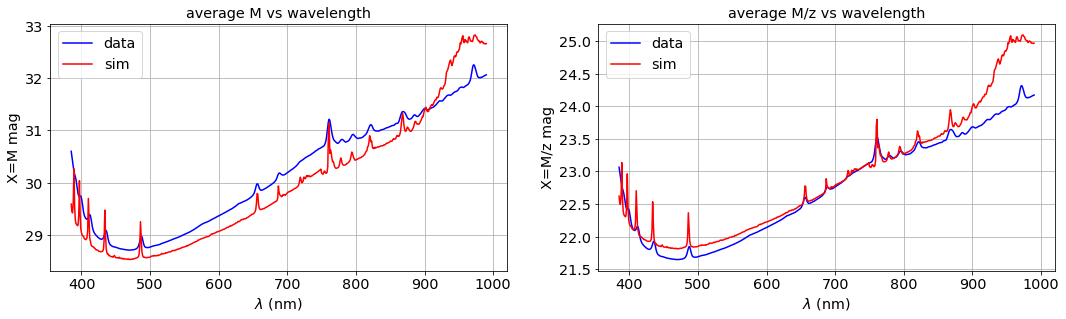

In [299]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    ax.plot(wl_atm,Xdataav[:NWL],"b-",label="data")
    ax.plot(wl_atm,Xsimav[:NWL],"r-",label="sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.legend()
    ax.set_title("average M vs wavelength")
    
    ax=fig.add_subplot(222)
    ax.plot(wl_atm,Xdataav[NWL:2*NWL],"b-",label="data")
    ax.plot(wl_atm,Xsimav[NWL:2*NWL],"r-",label="sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M/z mag")
    ax.grid()
    ax.legend()
    ax.set_title("average M/z vs wavelength")
    
   

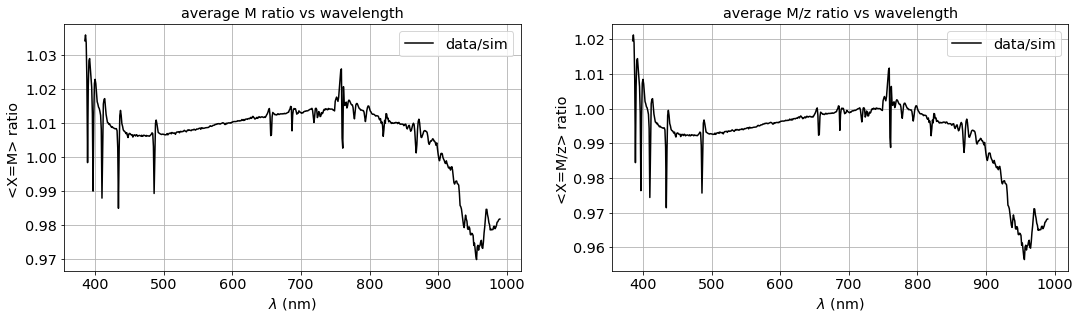

In [300]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    ax.plot(wl_atm,Xdataav[:NWL]/Xsimav[:NWL],"k-",label="data/sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M ratio vs wavelength")
    
    ax=fig.add_subplot(222)
    ax.plot(wl_atm,Xdataav[NWL:2*NWL]/Xsimav[NWL:2*NWL],"k-",label="data/sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M/z> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M/z ratio vs wavelength")

2020-10-12 16:05:21,213 MacBook-Pro-de-admin.local matplotlib.legend[44777] WARNING No handles with labels found to put in legend.
2020-10-12 16:05:21,323 MacBook-Pro-de-admin.local matplotlib.legend[44777] WARNING No handles with labels found to put in legend.


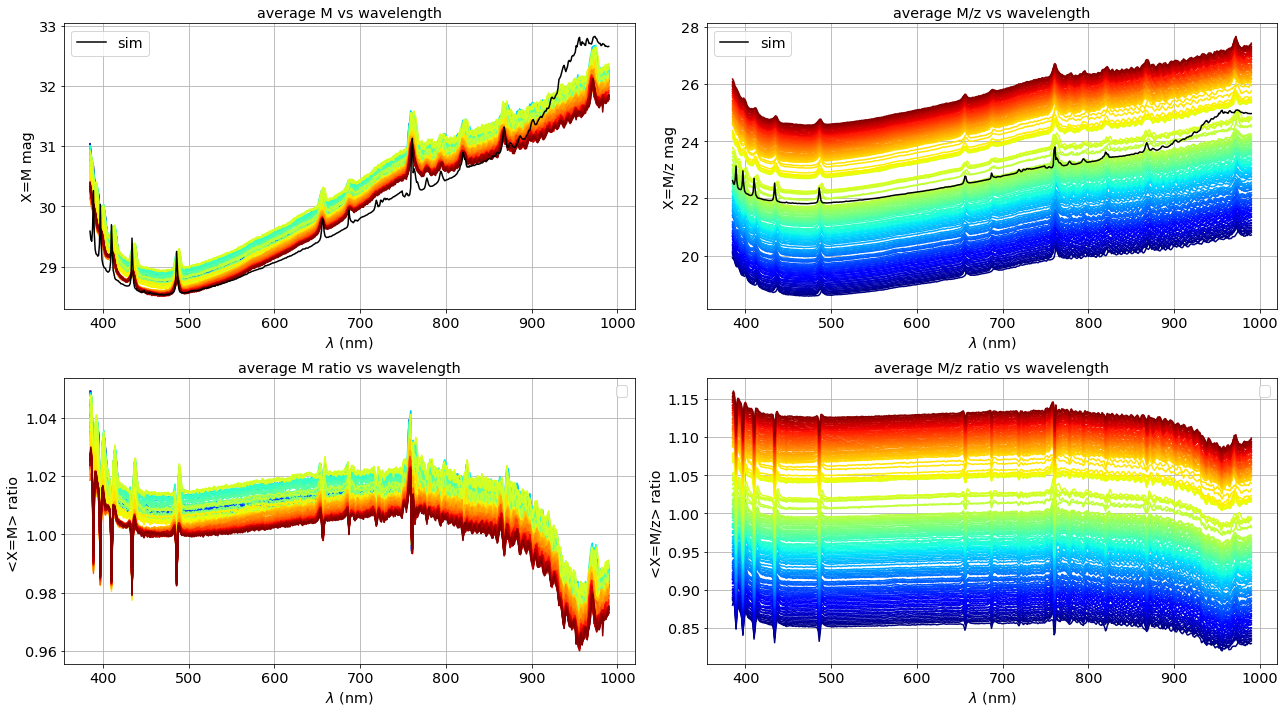

In [301]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    N=152
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(N):
        ax.plot(wl_atm,X[idx,:NWL],"-",color=all_colors[idx])
        
    ax.plot(wl_atm,Xsimav[:NWL],"k-",label="sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.legend()
    ax.set_title("average M vs wavelength")
    
    ax=fig.add_subplot(222)
    N=152
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(N):
        ax.plot(wl_atm,X[idx,NWL:2*NWL],"-",color=all_colors[idx])
        
    ax.plot(wl_atm,Xsimav[NWL:2*NWL],"k-",label="sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M/z mag")
    ax.grid()
    ax.legend()
    ax.set_title("average M/z vs wavelength")
    
    
    ax=fig.add_subplot(223)
    for idx in np.arange(N):
        ax.plot(wl_atm,X[idx,:NWL]/Xsimav[:NWL],"-",color=all_colors[idx])
        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M ratio vs wavelength")
    
    ax=fig.add_subplot(224)
    for idx in np.arange(N):
        ax.plot(wl_atm,X[idx,NWL:2*NWL]/Xsimav[NWL:2*NWL],"-",color=all_colors[idx])
        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M/z> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M/z ratio vs wavelength")
    
    
    plt.tight_layout()

# Scaling from selected sim data

In [302]:
X_diff = X-scaler_xmean
X_scale=X_diff/np.sqrt(scaler_xvar)

In [303]:
#X_scale=scalersim_X.transform(X)

In [304]:
Xsim_diff = Xsim-scaler_xmean
Xsim_scale=Xsim_diff/np.sqrt(scaler_xvar)

### Rescale with selected sim 

In [305]:
FLAG_RESCALE=True

In [306]:
scalersim_X.fit(Xsim[index_sim,:]) 
scalersim_Y.fit(Ysim[index_sim,:]) 

StandardScaler()

In [307]:
scalersim_X.transform([X[0,:]])[0]

array([ 7.16805778,  7.14545179,  6.52990417, ..., -1.79208622,
       -1.79655809, -1.7916161 ])

In [308]:
if FLAG_RESCALE:
    X_scale=np.zeros(X.shape)
    for idx in np.arange(X.shape[0]):
        if idx<152 or idx>203:
            X_scale[idx,:]=scalersim_X.transform([X[idx,:]])[0]
    Xsim_scale=scalersim_X.transform(Xsim)
    
    Ysim_scale=scalersim_Y.transform(Ysim)

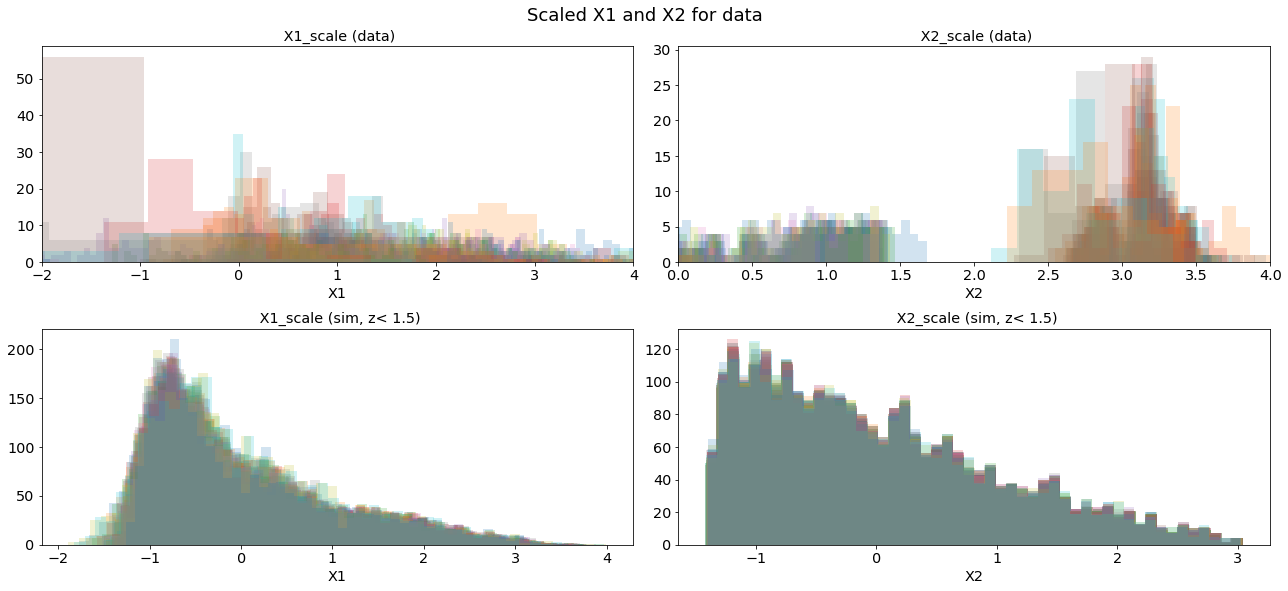

In [309]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,8))
    ax = fig.add_subplot(221)
    for iwl in np.arange(0,NWL,20):
        ax.hist(X_scale[:152,iwl],bins=50,alpha=0.2)
        ax.hist(X_scale[203:,iwl],bins=50,alpha=0.2)
    ax.set_title(" X1_scale (data)")
    ax.set_xlim(-2.,4)
    ax.set_xlabel("X1")
    
    ax = fig.add_subplot(222)
    for iwl in np.arange(0,NWL,20):
        ax.hist(X_scale[:152,NWL+iwl],bins=50,alpha=0.2)
        ax.hist(X_scale[203:,NWL+iwl],bins=50,alpha=0.2)
    ax.set_title(" X2_scale (data)")
    ax.set_xlim(0,4)
    ax.set_xlabel("X2")
    
    ax = fig.add_subplot(223)
    for iwl in np.arange(0,NWL,20):
        ax.hist(Xsim_scale[index_sim,iwl],bins=50,alpha=0.2)
    ax.set_title(" X1_scale (sim, z< 1.5)")
    #ax.set_xlim(0,4)
    ax.set_xlabel("X1")
    
    ax = fig.add_subplot(224)
    for iwl in np.arange(0,NWL,20):
        ax.hist(Xsim_scale[index_sim,NWL+iwl],bins=50,alpha=0.2)
    ax.set_title(" X2_scale (sim, z< 1.5)")
    #ax.set_xlim(0,4)
    ax.set_xlabel("X2")
    
    plt.suptitle("Scaled X1 and X2 for data",Y=1.02,fontsize=18)
    plt.tight_layout()

# Selected simulation

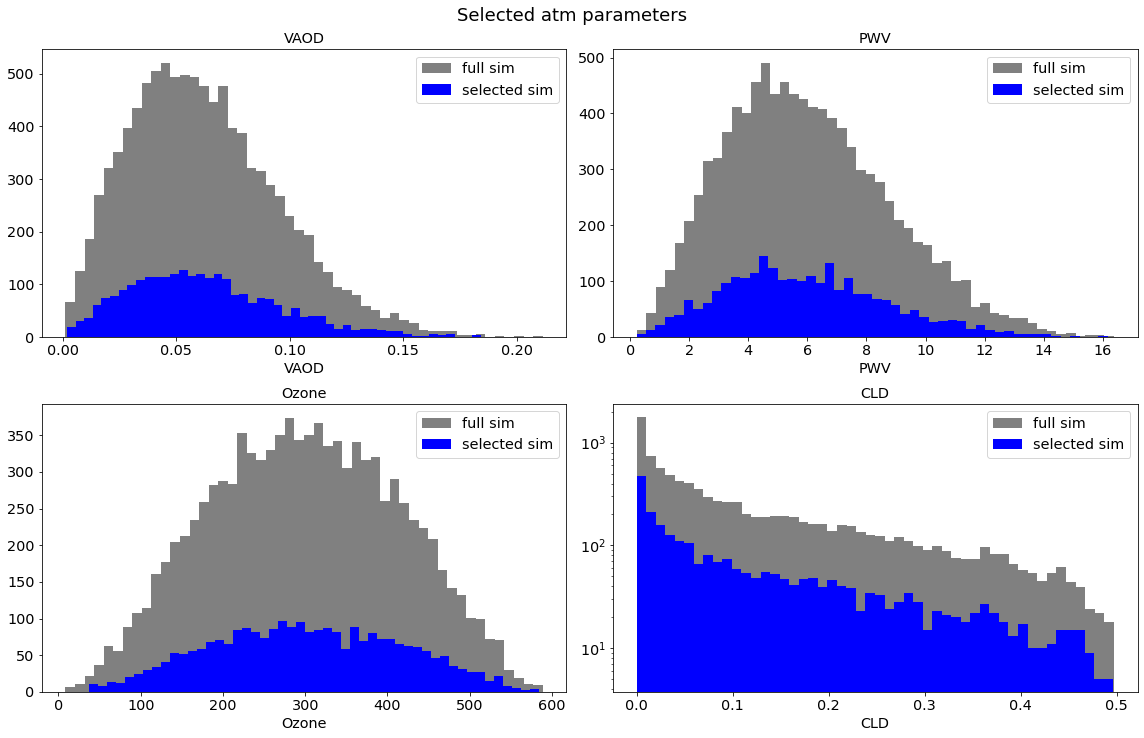

In [310]:

if FLAG_PLOT:
    fig=plt.figure(figsize=(16,10))
       
    ax = fig.add_subplot(221)
    ax.hist(Ysim[:,0],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[index_sim,0],bins=50,facecolor="b",label="selected sim")
    ax.set_title("VAOD")
    ax.set_xlabel("VAOD")
    ax.legend()
    
    
    ax = fig.add_subplot(222)
    ax.hist(Ysim[:,1],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[index_sim,1],bins=50,facecolor="b",label="selected sim")  
    ax.set_title("PWV")
    ax.set_xlabel("PWV")
    ax.legend()
       
        
    ax = fig.add_subplot(223)
    ax.hist(Ysim[:,2],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[index_sim,2],bins=50,facecolor="b",label="selected sim")
    ax.set_title("Ozone")
    ax.set_xlabel("Ozone")
    ax.legend()
    
    
    ax = fig.add_subplot(224)
    ax.hist(Ysim[:,3],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[index_sim,3],bins=50,facecolor="b",label="selected sim")  
    ax.set_title("CLD")
    ax.set_xlabel("CLD")
    ax.set_yscale("log")
    ax.legend()
    
    plt.suptitle("Selected atm parameters",Y=1.02,fontsize=18)
    plt.tight_layout()

# Nan

In [311]:
np.argwhere(np.isnan(X_scale))

array([], shape=(0, 2), dtype=int64)

# Prediction Data and Sim

## Make the model from selected sims 

In [312]:
alpha_ridge=1e-3
ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)

In [313]:
ridge.fit(Xsim_scale[index_sim,:],Ysim_scale[index_sim,:])

Ridge(alpha=0.001)

In [314]:
ridge.coef_

array([[ 0.7530387 ,  0.7117145 ,  0.66567154, ..., -0.2396754 ,
        -0.37565161, -0.36382503],
       [-0.01595758, -0.01657888, -0.01717824, ..., -0.82606573,
        -1.13094672, -1.0173936 ],
       [ 0.461627  ,  0.44796738,  0.4321561 , ...,  0.43554022,
         0.42236417,  0.41680255],
       [-0.96806584, -0.92826838, -0.88318724, ..., -2.38993001,
        -2.44892602, -2.39924473]])

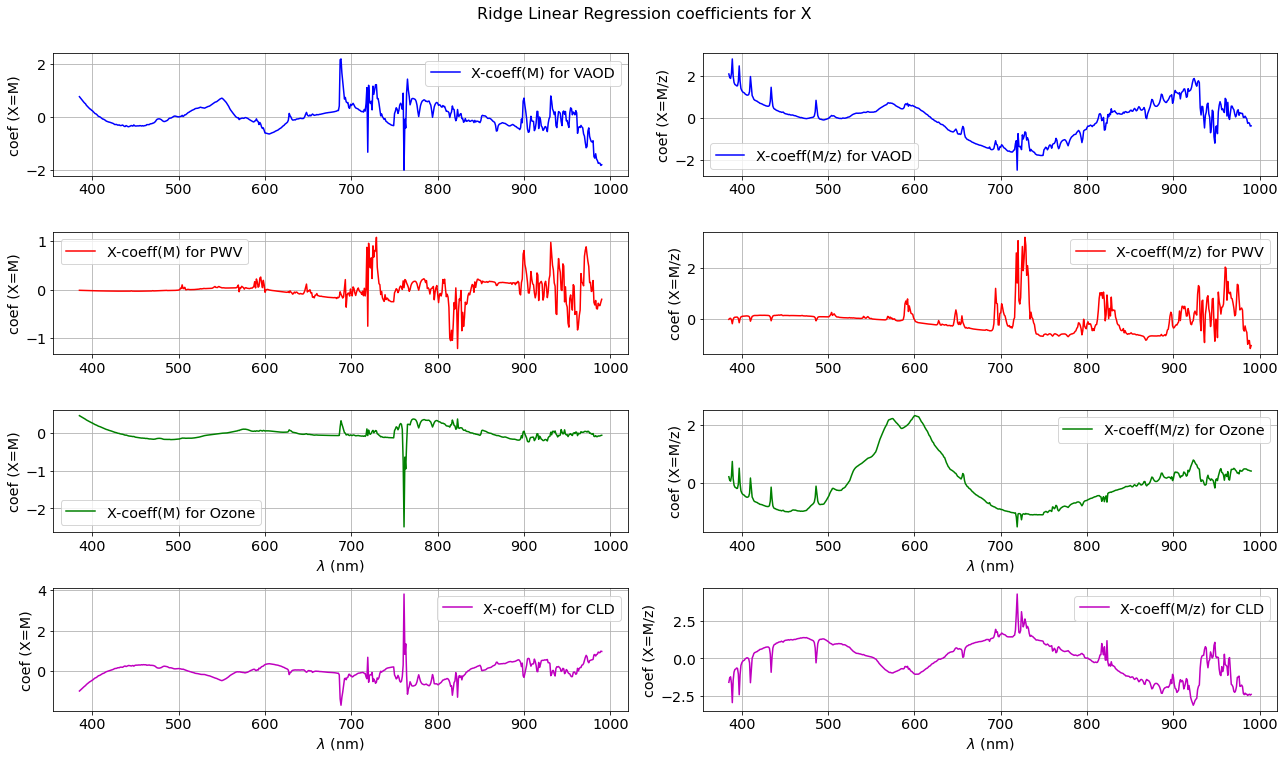

In [315]:
if FLAG_PLOT: 
    fig=plt.figure(figsize=(18,10))

    ax = fig.add_subplot(421)
    ax.plot(wl_atm,ridge.coef_[0][0:NWL],'b-',label="X-coeff(M) for VAOD")        
    #ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M)")
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(422,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[0][NWL:2*NWL],'b-',label="X-coeff(M/z) for VAOD")

    #ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M/z)")
    ax.grid()
    ax.legend()


    ax = fig.add_subplot(423,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[1][0:NWL],'r-',label="X-coeff(M) for PWV")        
    #ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M)")
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(424,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[1][NWL:2*NWL],'r-',label="X-coeff(M/z) for PWV")

    #ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M/z)")
    ax.grid()
    ax.legend()


    ax = fig.add_subplot(425,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[2][0:NWL],'g-',label="X-coeff(M) for Ozone")        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M)")
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(426,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[2][NWL:2*NWL],'g-',label="X-coeff(M/z) for Ozone")

    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M/z)")
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(427,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[3][0:NWL],'m-',label="X-coeff(M) for CLD")        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M)")
    ax.grid()
    ax.legend()

    ax = fig.add_subplot(428,sharex=ax)
    ax.plot(wl_atm,ridge.coef_[3][NWL:2*NWL],'m-',label="X-coeff(M/z) for CLD")

    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("coef (X=M/z)")
    ax.grid()
    ax.legend()

    plt.tight_layout()
    plt.suptitle("Ridge Linear Regression coefficients for X",Y=1.05,fontsize=16)

In [316]:
#Y_pred_scale=linearregression_model.predict([X_scale[0,:]])
Y_pred_scale=ridge.predict([X_scale[0,:]])

In [317]:
NPARAM=len(Y_pred_scale[0])

In [318]:
all_Y_pred_scale_data=np.zeros((NBFILES_GOOD,NPARAM))

In [319]:
FLAG_DATA = np.full(NBFILES_GOOD, True)
FLAG_DATA[152:202]=False

## Predict Y_scale from X_scale in data

In [320]:
for idx in np.arange(NBFILES_GOOD):
    if not FLAG_DATA[idx] :
        continue
    #y=linearregression_model.predict([X_scale[idx,:]])[0]
    y=ridge.predict([X_scale[idx,:]])[0]
    all_Y_pred_scale_data[idx,:]=y

In [321]:
# remove bad rows for data
all_Y_pred_scale_data_selected=np.delete(all_Y_pred_scale_data,np.arange(152,202),axis=0)

## Predict Y_scale from X_scale in simulation

In [322]:
# 
#all_Y_pred_scale_sim=linearregression_model.predict(Xsim_scale[index_sim,:])
all_Y_pred_scale_sim=ridge.predict(Xsim_scale[index_sim,:])

# Inverse transform of scaler

In [325]:
Y_data_rec=scalersim_Y.inverse_transform(all_Y_pred_scale_data_selected)

In [326]:
Y_sim_rec=scalersim_Y.inverse_transform(all_Y_pred_scale_sim)

# Plot

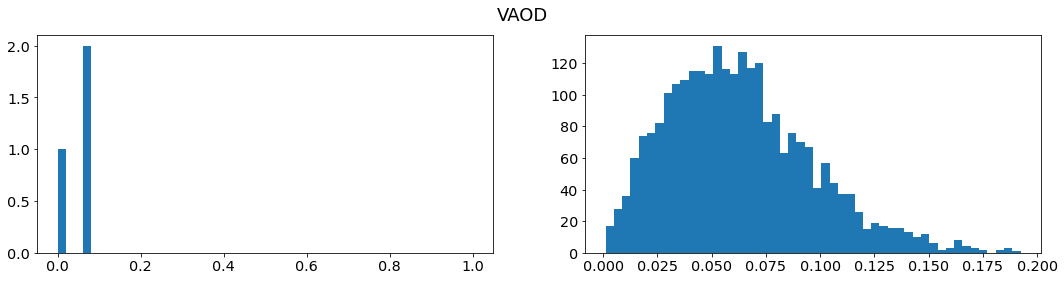

In [327]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Y_data_rec[:,0],bins=50,range=(0,1));
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Y_sim_rec[:,0],bins=50);
    
    plt.suptitle("VAOD",fontsize=18)

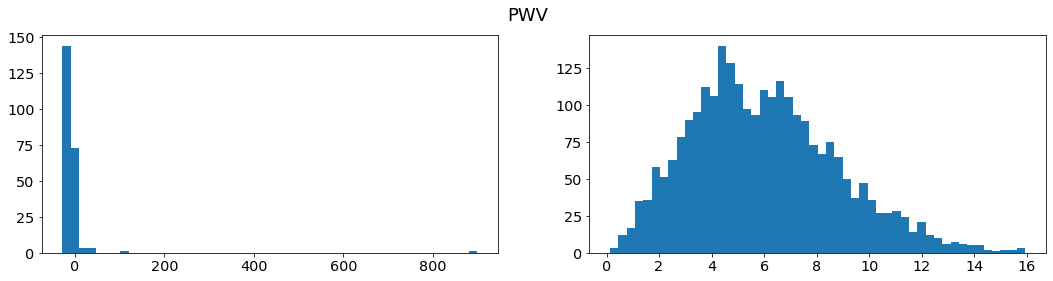

In [328]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Y_data_rec[:,1],bins=50);
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Y_sim_rec[:,1],bins=50);
    plt.suptitle("PWV",fontsize=18)

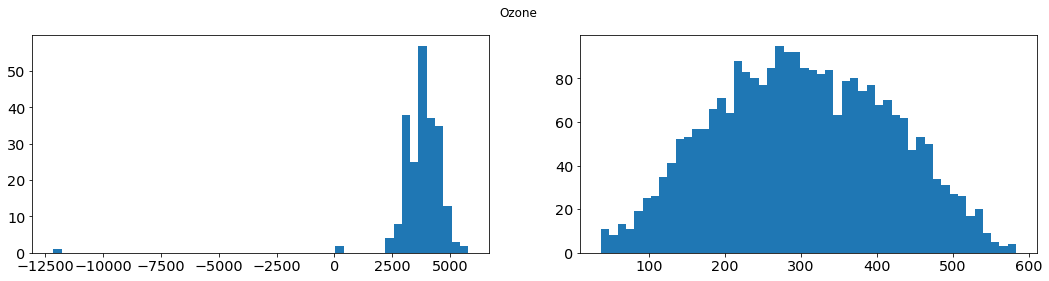

In [329]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Y_data_rec[:,2],bins=50);
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Y_sim_rec[:,2],bins=50);
    plt.suptitle("Ozone")

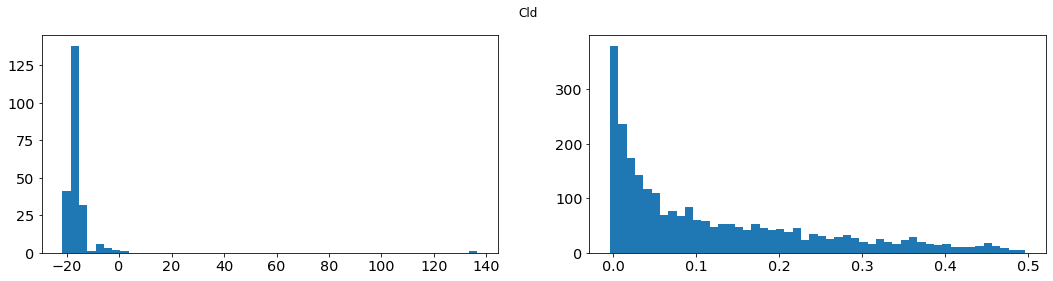

In [330]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Y_data_rec[:,3],bins=50);
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Y_sim_rec[:,3],bins=50);
    plt.suptitle("Cld")